# Create Confusion Matrix

In [1]:
from BCM_dataset_v2 import bcmDataset
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


Dataset version: 2.1


In [2]:
# Load a previously trained model

from BCM_dataset_v2 import concat_train_test_datasets


model_loaded = torch.jit.load('trained_models/oct_31')
model_loaded.eval()

# Create a dataset
#ds = bcmDataset('data/bcm/4.npy', class_id = 4, window_size = 3, stride = 3, MFCC_stride = 0.032)
_, ds = concat_train_test_datasets('data/bcm', window_size = 3, MFCC_stride = 0.032)


Validation set
data/bcm/validation/0.npy
data/bcm/validation/1.npy
data/bcm/validation/2.npy
data/bcm/validation/3.npy
data/bcm/validation/4.npy
Training set
data/bcm/train/0.npy
data/bcm/train/1.npy
data/bcm/train/2.npy
data/bcm/train/3.npy
data/bcm/train/4.npy


In [3]:

preds = np.zeros(len(ds))
y = np.zeros(len(ds))


for i in range(0, len(ds)):
    # Remeber to insert empty/None dimension to test a single datapoint!!!!!!!!!
    test = ds[i][0]
    test = test[None,:,:]
    preds[i] = model_loaded(test).argmax()
    y[i] = ds[i][1].argmax()
    
# Cell takes approx 6 mins to run


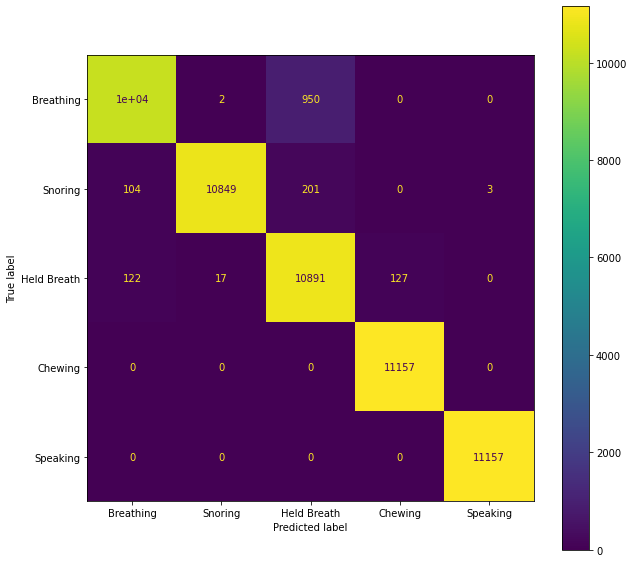

In [4]:
conf_mat = confusion_matrix(y, preds)
fig, ax = plt.subplots(figsize=(10, 10))

cm = confusion_matrix(y, preds, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Breathing','Snoring','Held Breath','Chewing','Speaking'])
fig.patch.set_facecolor('white')
disp.plot(ax = ax)



# Traceable dataset

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
from python_speech_features import mfcc
import matplotlib.pyplot as plt
import tracemalloc
from SerialTriggerDecoder import SerialTriggerDecoder
from scipy import signal

In [6]:
# Load the jitted model
from BCM_dataset_v2 import concat_train_test_datasets
model_loaded = torch.jit.load('trained_models/oct_31')
model_loaded.eval()

RecursiveScriptModule(
  original_name=LSTM_Model
  (lstm): RecursiveScriptModule(original_name=LSTM)
  (flatten): RecursiveScriptModule(original_name=Flatten)
  (fc): RecursiveScriptModule(original_name=Linear)
  (output): RecursiveScriptModule(original_name=Sigmoid)
  (sm): RecursiveScriptModule(original_name=Softmax)
  (loss): RecursiveScriptModule(original_name=CrossEntropyLoss)
  (accuracy): RecursiveScriptModule(original_name=Accuracy)
  (val_accuracy): RecursiveScriptModule(original_name=Accuracy)
)

In [7]:
raw_file = h5py.File('bcm_activity_dataset/2022-09-20_14-58-39.hdf5', 'r')
data_full = np.array(raw_file['DAQ970A']['data'])
data_ear_1 = data_full[:,0]
data_ear_2 = data_full[:,1]
labels = data_full[:,3]

last_decoded = -500000
label_index_list = [] # List of the indices of the labels
for i, j in enumerate(np.rint(labels)):
    
    if int(j) and (i > last_decoded+50000*8):
        print(f"i: {i}")
        print(f"Time: {i/50000} s")
        last_decoded = i
        
        label_index_list.append(i)

i: 19492
Time: 0.38984 s
i: 519489
Time: 10.38978 s
i: 1019486
Time: 20.38972 s
i: 1519483
Time: 30.38966 s
i: 2019481
Time: 40.38962 s
i: 2519478
Time: 50.38956 s
i: 3019475
Time: 60.3895 s
i: 3519472
Time: 70.38944 s
i: 4019470
Time: 80.3894 s
i: 4519467
Time: 90.38934 s
i: 5020452
Time: 100.40904 s
i: 5520449
Time: 110.40898 s
i: 6020446
Time: 120.40892 s
i: 6520443
Time: 130.40886 s
i: 7020440
Time: 140.4088 s
i: 7520438
Time: 150.40876 s
i: 8020435
Time: 160.4087 s
i: 8520432
Time: 170.40864 s
i: 9020429
Time: 180.40858 s
i: 9520427
Time: 190.40854 s
i: 10022045
Time: 200.4409 s
i: 10522042
Time: 210.44084 s
i: 11022039
Time: 220.44078 s
i: 11522036
Time: 230.44072 s
i: 12022033
Time: 240.44066 s
i: 12522031
Time: 250.44062 s
i: 13022028
Time: 260.44056 s
i: 13522025
Time: 270.4405 s
i: 14022022
Time: 280.44044 s
i: 14522019
Time: 290.44038 s
i: 15023764
Time: 300.47528 s
i: 15523762
Time: 310.47524 s
i: 16009096
Time: 320.18192 s
i: 16523756
Time: 330.47512 s
i: 17023753
Time: 34

In [8]:
index_labels = [] # A list of labels for the indexes in label_index_list

for i in range(6):
    index_labels.extend([0,0,0,1,1,1,2,2,2,-1])

for i in range(18): index_labels.append(3)
index_labels.append(-1)

for i in range(18): index_labels.append(4)
index_labels.append(-1)

labels_np = np.array(index_labels)
labels_np = np.repeat(labels_np, 500000)

labels_np = np.hstack((np.zeros(label_index_list[0]), labels_np))




In [9]:
print(labels_np.shape)
print(data_ear_1.shape)


(49019492,)
(49000000,)


In [10]:
# Create mfccs and labels
fs = 50000
data_mfcc = mfcc(data_ear_1, samplerate = fs, nfft = 1600, winlen=0.032, winstep=0.032, numcep=16)
labels_mfcc = labels_np[::1600]

print(data_mfcc.shape)
print(labels_mfcc.shape)


(30625, 16)
(30638,)


In [11]:

# Use the model to predict the labels
preds_list = []
for i in range(0, len(data_mfcc)):
    # Remeber to insert empty/None dimension to test a single datapoint!!!!!!!!!
    if i + 93 > len(data_mfcc):
        break
    
    test = data_mfcc[i:i+93]
    test = torch.from_numpy(test[None,:,:]).float()
    preds_list.append(model_loaded(test).argmax())
    
# Takes approx. 4 min. to run on cpu

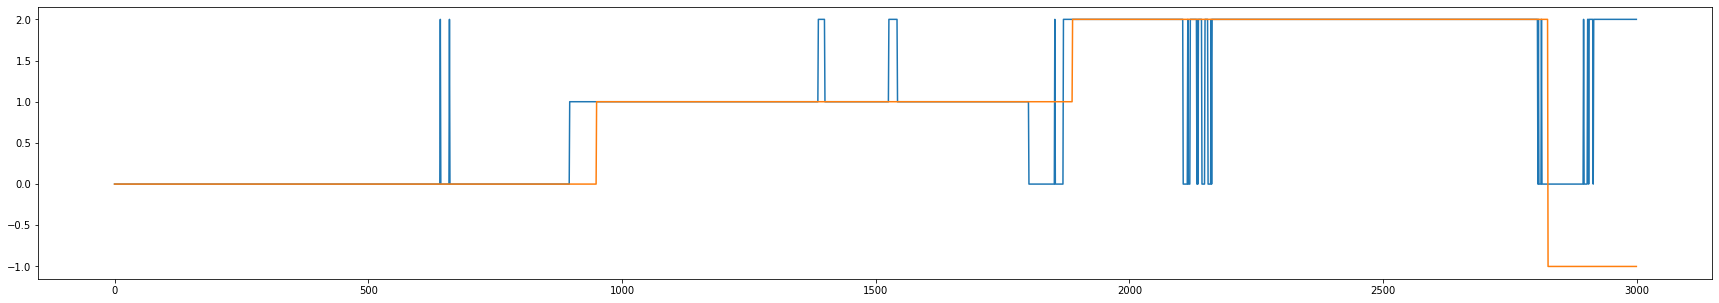

In [12]:
seg_len = 3000
seg_pos = 0

w = 100
# smoothed_preds = np.convolve(np.array(preds_list), np.ones(w), 'valid') / w


# Plot preds_list
fig = plt.figure(figsize=(30, 5))
plt.plot(preds_list[seg_pos:seg_pos+seg_len])
#plt.plot(np.round(smoothed_preds[seg_pos:seg_pos+seg_len]))
plt.plot(labels_mfcc[seg_pos:seg_pos+seg_len])
plt.show()

In [13]:
# Find all the places where the predictions are wrong
from scipy.io.wavfile import write
amplitude = np.iinfo(np.int16).max

wrong_preds = []
error_seg_len = []
for i in range(len(preds_list)): # Find the locations of the error segments
    if preds_list[i] != labels_mfcc[i] and labels_mfcc[i] != -1: # Only include if it's a new segment
        if preds_list[i-1] == labels_mfcc[i-1]:
            wrong_preds.append(i)
            j = i
            
            while preds_list[j] != labels_mfcc[j]: # Find the length of the misclassified segment
                j += 1 
            error_seg_len.append(j-i)    
            
            # Save a file
            if (j - i) > 50:
                print(i)
                print(j)
                print(int(i*(50000*0.032)))
                print(int(j*(50000*0.032)))
                test_sig = data_ear_1[int(i*(50000*0.032)):int(j*(50000*0.032))]
                print(test_sig)
                test_sig = (test_sig - np.mean(test_sig)) / np.std(test_sig)
                test_sig = test_sig/max(abs(test_sig))
                test_sig = test_sig* amplitude
                write(f"error_sound_files/error_pred_{preds_list[i]}_y_{labels_mfcc[i]}_len_{j-i}.wav", 50000, test_sig.astype(np.int16))
        
        
print(f"Number of wrong predictions: {len(wrong_preds)}")

for i in range(len(wrong_preds)):
    print(f"Position: {wrong_preds[i]}, Length: {error_seg_len[i]}")


897
950
1435200
1520000
[-0.7131421  -0.7131691  -0.71318614 ... -0.713062   -0.71306294
 -0.71307194]
1802
1888
2883200
3020800
[-0.715289   -0.7153018  -0.71532315 ... -0.74238306 -0.7423712
 -0.7423627 ]
2813
3138
4500800
5020800
[-0.736299   -0.7363023  -0.7363094  ... -0.73563844 -0.7356413
 -0.7356394 ]
3481
3538
5569600
5660800
[-0.738934   -0.73893255 -0.7389307  ... -0.7399063  -0.7399134
 -0.7399191 ]
4006
4075
6409600
6520000
[-0.7393818  -0.73938036 -0.73938084 ... -0.74399555 -0.7439965
 -0.7439851 ]
6653
6749
10644800
10798400
[-0.7677983 -0.767803  -0.7678125 ... -0.7593697 -0.7593284 -0.7592886]
7127
7200
11403200
11520000
[-0.76550347 -0.7655002  -0.7654935  ... -0.78168267 -0.7816817
 -0.7816917 ]
8116
8257
12985600
13211200
[-0.7708579  -0.7709119  -0.77096164 ... -1.0753202  -1.0753288
 -1.0753373 ]
9553
9629
15284800
15406400
[-0.7165689  -0.7165689  -0.71656555 ... -0.6867749  -0.6867877
 -0.68679386]
10254
10325
16406400
16520000
[-0.7342174 -0.7342169 -0.7342018

In [14]:
#Plot segments where the predictions are wrong
error_index += 1

segment_len = 100
segment_pos = wrong_preds[error_index]
print(f"Segment position: {segment_pos}")

if segment_pos < segment_len: segment_pos = segment_len # Make sure the segment is not before the start of the data
    
print(f"Segment position: {segment_pos}")

t1 = np.linspace(0, 2*segment_len*0.032, segment_len*2) # Create an acurate time vector for mfcc windows
t2 = np.linspace(0, 2*segment_len*0.032, int(segment_len*2*0.032*50000)) # Create an acurate time vector for raw data

fig = plt.figure(figsize=(30, 5))
plt.subplot(3,1,1)

plt.pcolormesh((data_mfcc[segment_pos -segment_len: segment_pos + segment_len].transpose()),shading='auto')
plt.ylabel('Mel Cepstrum Coefficients')
plt.xlabel('MFCC Windows')

plt.subplot(3,1,2)

plt.plot(t2,data_ear_1[segment_pos*1600 -segment_len*1600: segment_pos*1600 + segment_len*1600])
plt.ylabel('Raw Signal')
plt.xlabel('Time [sec]')

plt.subplot(3,1,3)

plt.plot(t1,labels_mfcc[segment_pos -segment_len: segment_pos + segment_len])
plt.ylabel('Actual Label')
plt.xlabel('Time [sec]')
fig.set_figheight(15)


plt.plot(t1,preds_list[segment_pos -segment_len: segment_pos + segment_len])
plt.ylabel('Predicted label')
plt.xlabel('Time [sec]')

plt.show()


NameError: name 'error_index' is not defined